In [7]:
import requests
import base64

def fetch_conversation_feedback(username, password):  
    """Create headers with Base64 encoded credentials."""
    credentials = f"{username}:{password}"
    encoded_credentials = base64.b64encode(credentials.encode("utf-8")).decode("utf-8")
    headers = {
        'accept': 'application/json',
        'Authorization': f'Basic {encoded_credentials}'
    }

    """Fetch conversation and feedback data."""
    feedback_url = f'http://localhost:8000/ui/get_feedback'
    
    try:
        response = requests.get(feedback_url, headers=headers)
        response.raise_for_status()

        try:
            data = response.json()
        except ValueError:
            print("Error decoding JSON from response.")
            return None
        
        if not data:
            print("No data received.")
            return None
        
        # Create dictionaries to hold user questions and system answers
        questions = {message["message_id"]: message for message in data if message["role"] == "user"}
        answers = {message["parent_id"]: message for message in data if message["role"] == "system"}
        
        # Return questions, answers
        # Organize into Q&A pairs
        qa_pairs = []
        for q_id, question in questions.items():
            if q_id in answers:
                qa_pairs.append({
                    "question": question["content"],
                    "answer": answers[q_id]["content"],
                    "feedback": answers[q_id]["feedback"]
                })
        
        return qa_pairs
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return None

In [8]:
conversation_data = fetch_conversation_feedback("supportai", "supportai")

In [9]:
conversation_data

[{'question': 'How many transactions are there?',
  'answer': 'The total number of transactions is 860142.',
  'feedback': 1}]

In [8]:
import openai
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

openai.api_key = 'OPENAI_API_KEY'

questions = []
feedbacks = []
for i in conversation_data.values():
    for j in i:
        questions.append(j.get('question'))
        feedbacks.append(j.get('feedback'))

def get_embeddings(questions):
    response = openai.embeddings.create(
        input=questions,
        model="text-embedding-ada-002"
    )
    return [embedding.embedding for embedding in response.data]

embeddings = get_embeddings(questions)

# Determine the optimal number of clusters using the elbow method
def plot_elbow_method(embeddings, max_clusters=10):
    inertias = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=0)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia/WCSS')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.show()

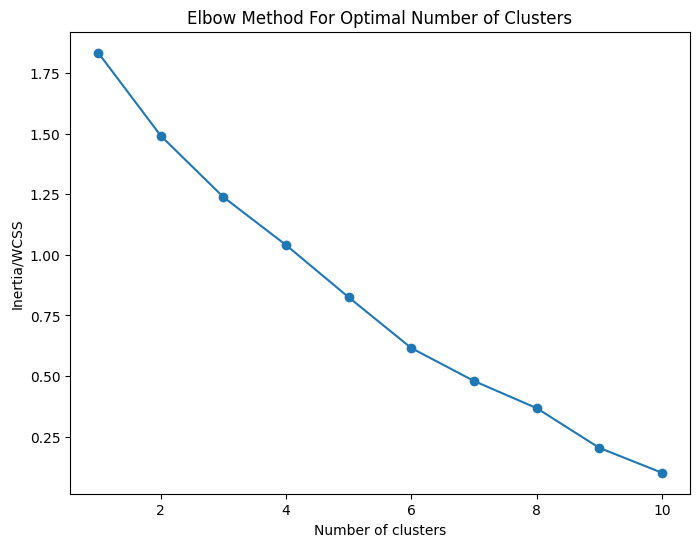

In [9]:
# Plot the elbow method graph to determine the best number of clusters
plot_elbow_method(embeddings)

In [10]:
optimal_cluster = 6

kmeans = KMeans(n_clusters=optimal_cluster, random_state=0)
kmeans.fit(embeddings)
labels = kmeans.labels_

In [11]:
# Group questions by their cluster labels
clustered_questions = {i: [] for i in range(optimal_cluster)}
for i, label in enumerate(labels):
    clustered_questions[label].append(questions[i])

In [12]:
def generate_summary(questions):

    # Call OpenAI API to generate a summary
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "you are an expert to summary texts into a short and concise theme"},
            {"role": "user", "content":f"summarize the following questions into a main theme, and only return the label of theme, questions: {questions}"}
        ],
        max_tokens=20,
        temperature=0.1
    )
    
    # Extract and return the generated summary
    summary = response.choices[0].message.content.strip()
    return summary

In [13]:
main_themes = {}

# Print questions for each cluster and use ChatGPT to summarize the main theme
for cluster, qs in clustered_questions.items():
    print(f"Cluster {cluster}:")
    for q in qs:
        print(f"  - {q}")
    # Summarize main theme using ChatGPT or another method
    theme_summary = generate_summary(qs)  # Define this function or use an LLM
    print(f"Main theme: {theme_summary}\n")
    main_themes[cluster] = theme_summary

Cluster 0:
  - Provide more details about this transaction 871054, like the card used and merchant involved in this transaction.
  - Are there any activities of the user associated with transaction 871054 that might be interesting to look into for further investigation? 
  - What are more details of the transaction 565964?
Main theme: Transaction Details and Investigation

Cluster 1:
  - what is the merchant involved in this transaction?
  - What do we know about this merchant?
Main theme: Merchant Information

Cluster 2:
  - Find all transactions, from 2/1/21 to 5/1/21 above average amount for that card. Sort the results.
  - List all merchants that have more than 2500 transactions from 2021-02-01 to 2021-10-01.
Main theme: Transaction Analysis

Cluster 3:
  - what is the card used in this transaction?
  - What is the ID of the card used in transaction 565964?
Main theme: Card Transaction Identification

Cluster 4:
  - List the largest 10 transactions made by the merchant fraud_Kuhn L

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_kmeans_clusters(embeddings, feedbacks, optimal_clusters):
    """
    Perform KMeans clustering, reduce dimensions using PCA, and plot the clusters in 2D.

    Parameters:
    - embeddings: Array-like, shape (n_samples, n_features)
        The input data to be clustered.
    - feedbacks: Array-like, shape (n_samples,)
        An array indicating the type of feedback for each sample (1 or 2).
    - optimal_clusters: int
        The number of clusters to form.

    Returns:
    - None: Displays a 2D plot of the clustered data.
    """

    # Perform KMeans clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
    clusters = kmeans.fit_predict(embeddings)

    # Perform PCA to reduce dimensions to 2 for 2D plotting
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plotting the clusters in 2D
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define colors for clusters
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    # Plot each cluster with different color and annotate
    for cluster in range(optimal_clusters):
        cluster_points = reduced_embeddings[clusters == cluster]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster % len(colors)], label=f'Cluster {cluster}')

    for cluster in main_themes:
        cluster_center = kmeans.cluster_centers_[cluster]
        reduced_center = pca.transform([cluster_center])[0]
        ax.text(reduced_center[0], reduced_center[1], main_themes[cluster], fontsize=12, weight='bold')

    # Highlight feedback with different markers
    for i, (x, y) in enumerate(reduced_embeddings):
        if feedbacks[i] == 1:
            ax.scatter(x, y, c='black', marker='^')
        elif feedbacks[i] == 2:
            ax.scatter(x, y, c='black', marker='x')

    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend()
    plt.show()

    return clusters, main_themes

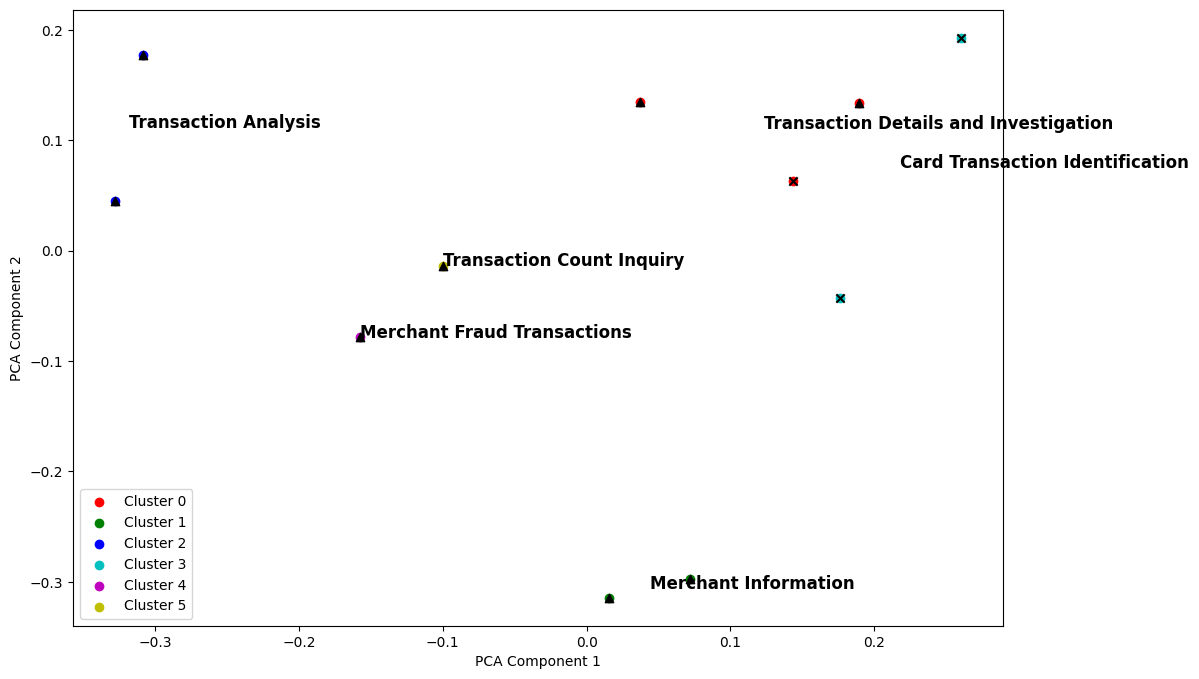

In [15]:
clusters, main_themes = plot_kmeans_clusters(embeddings, feedbacks, optimal_cluster)

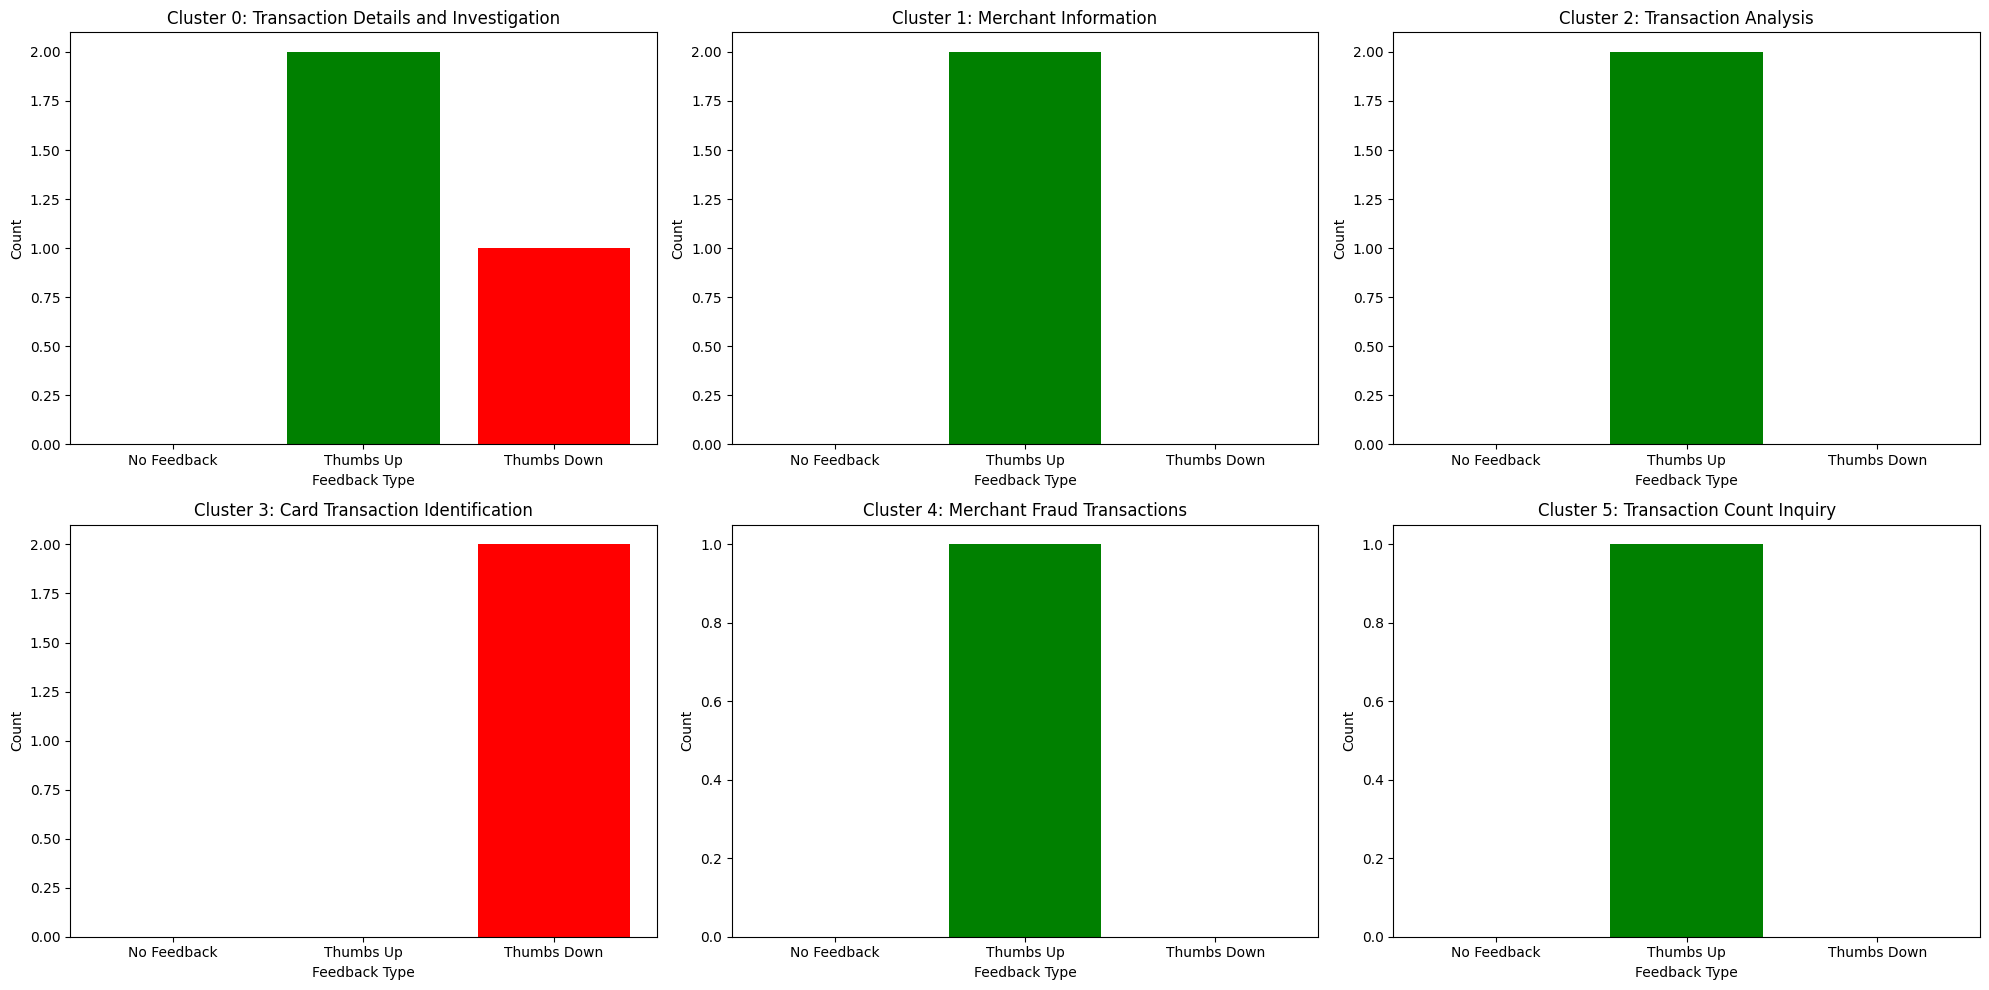

In [16]:
from collections import defaultdict

# Group questions by cluster
clustered_questions = defaultdict(list)
for i, cluster in enumerate(clusters):
    clustered_questions[cluster].append({'question': questions[i], 'feedback': feedbacks[i]})

# Create a conversation_data variable with clustered questions and feedback
conversation_data = []
for cluster, items in clustered_questions.items():
    for item in items:
        conversation_data.append({"question": item['question'], "feedback": item['feedback']})

# Plot feedback distribution in each cluster
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10)) # Adjust the nrow and ncols based on the number of clusters
axes = axes.flatten()

for cluster, items in clustered_questions.items():
    feedback_counts = defaultdict(int)
    for item in items:
        feedback_counts[item['feedback']] += 1
    
    feedback_types = ['No Feedback', 'Thumbs Up', 'Thumbs Down']
    counts = [feedback_counts[0], feedback_counts[1], feedback_counts[2]]
    
    axes[cluster].bar(feedback_types, counts, color=['gray', 'green', 'red'])
    axes[cluster].set_title(f'Cluster {cluster}: {main_themes.get(cluster, "Unknown")}')
    axes[cluster].set_xlabel('Feedback Type')
    axes[cluster].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
# After plotting feedback distribution, group and print all questions by feedback type in cluster 1
cluster_to_view = 3  # Change this to the cluster number you want to view

# Initialize a dictionary to store questions grouped by feedback type
grouped_by_feedback = defaultdict(list)

# Group questions by feedback type
for item in clustered_questions[cluster_to_view]:
    question = item['question']
    feedback = item['feedback']
    feedback_str = "No Feedback" if feedback == 0 else "Thumbs Up" if feedback == 1 else "Thumbs Down"
    grouped_by_feedback[feedback_str].append(question)

# Print questions grouped by feedback type
print(f"Questions in Cluster {cluster_to_view} grouped by feedback type:")

# Total number of questions in the cluster
total_questions = sum(len(questions) for questions in grouped_by_feedback.values())
print(f"Total number of questions: {total_questions}")

for feedback_type, questions in grouped_by_feedback.items():
    print(f"\nFeedback Type: {feedback_type} (Total: {len(questions)})")
    for question in questions:
        print(f"  - {question}")

Questions in Cluster 3 grouped by feedback type:
Total number of questions: 2

Feedback Type: Thumbs Down (Total: 2)
  - what is the card used in this transaction?
  - What is the ID of the card used in transaction 565964?
